In [2]:
import os
if 'examples' in os.getcwd(): os.chdir('../..')
print(os.getcwd())

import warnings
warnings.filterwarnings('ignore')

/home/bernie40916/Nas/home/Project/DJtransGAN


In [3]:
import torch
import matplotlib.pyplot as plt

from djtransgan.config    import settings
from djtransgan.utils     import wave_visualize, fft_visualize, mask_visualize
from djtransgan.mixer     import Mixer
from djtransgan.frontend  import get_amp2db_func, get_stft_func
from djtransgan.dataset   import get_dataset, batchlize

## Preparation 

In [4]:
stft_func   = get_stft_func()
amp2db_func = get_amp2db_func()

STFT kernels created, time used = 0.1693 seconds


## Mixer

### Data Prepareing

In [5]:
n_time       = 10
batch_size   = 4 

dataset      = get_dataset('noise', n_time=n_time)
dataloader   = iter(batchlize(dataset, batch_size))
waves        = next(dataloader)
mags, phases = stft_func(waves) # (batch_size, channels, bins, frames)

print('waves size: ', waves.size())
print('mags size: ' , mags.size())

waves size:  torch.Size([4, 441000])
mags size:  torch.Size([4, 1, 1025, 862])


### Mixer Usage

In [6]:
# Set Parameters

fader_args = {
    'sum_type'  : 'mean' ,
    'fade_type' : 'fi'   , 
    'fade_shape': 'linear',
}

band_args   = { 
    'sum_type'  : 'mean', 
    'band_type' : 'low', 
    'fade_shape': 'linear', 
    'split_type': 'equal',
    'out_type'  : 'mix'
}


n_band       = 4
n_fader      = 1
n_param      = 2

mixer        = Mixer(band_args, fader_args)
band_params  = torch.rand(batch_size, n_band - 1, 2)
fader_params = torch.rand(batch_size, n_band, n_fader, n_param)
cue_regions  = torch.tensor([0.4, 0.6])

In [7]:
mixer_mags, mixer_dict = mixer(mags, band_params, fader_params, cue_regions)

band_result  = mixer_dict['band']
fader_result = mixer_dict['fader']
mask_result  = mixer_dict['mask']

### Mixer Visualize

Spec Magnitude Visualze

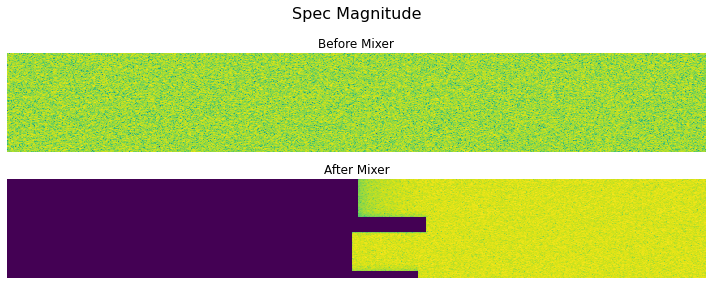

In [8]:
batch_idx  = 0 # Choose batch sample to visualize 
mixer_mags = mixer_mags if band_args['out_type'] == 'mix' else torch.sum(mixer_mags, axis=1)
    
fig, axes  = plt.subplots(2, 1, figsize=(10, 4))
for (use_mags, title, ax) in zip([mags, mixer_mags], ['Before', 'After'], axes):
    mask_visualize(amp2db_func(use_mags[batch_idx][0]), ax, title=f'{title} Mixer')
plt.suptitle('Spec Magnitude', fontsize=16)
plt.tight_layout()
plt.show()

Fader Curve Visualize

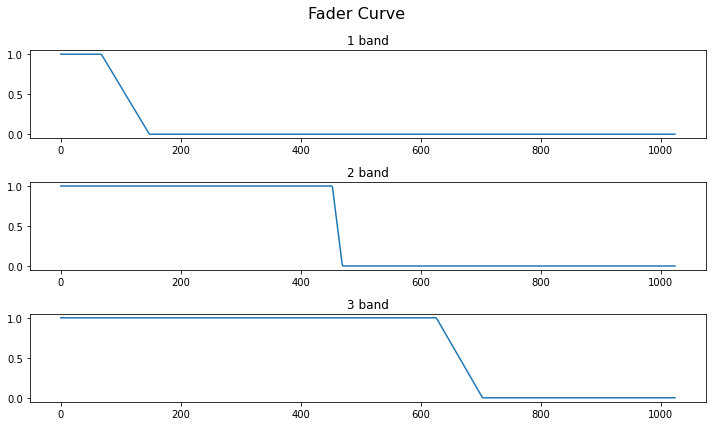

In [9]:
batch_idx  = 0 # Choose batch sample to visualize 
fig, axes  = plt.subplots(band_result.size(1), 1, figsize=(10, 6))
for index in range(band_result.size(1)):
    axes[index].plot(band_result[batch_idx][index][0])
    axes[index].set_title(f'{index + 1} band')

plt.suptitle('Fader Curve', fontsize=16)
plt.tight_layout()
plt.show()

Mask Visualize

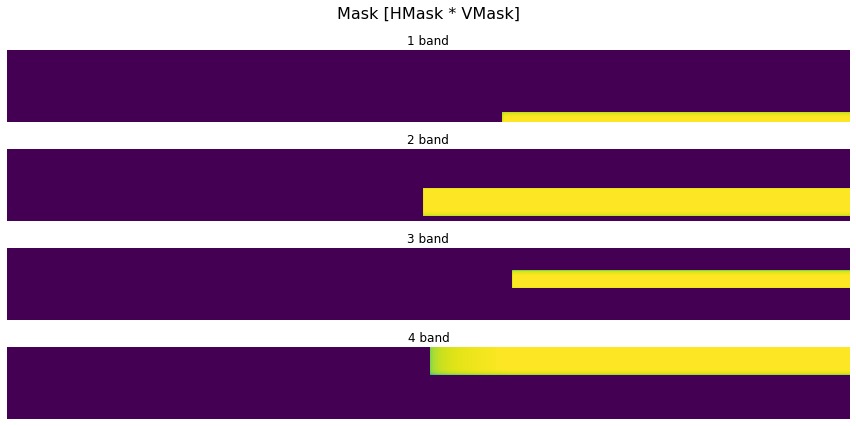

In [10]:
batch_idx  = 0 # Choose batch sample to visualize 
fig, axes  = plt.subplots(mask_result.size(1), 1, figsize=(12, 6)) 
for index in range(mask_result.size(1)):
    mask_visualize(amp2db_func(mask_result[batch_idx][index][0]), axes[index])
    axes[index].set_title(f'{index + 1} band')

plt.suptitle('Mask [HMask * VMask]', fontsize=16)
plt.tight_layout()
plt.show()

## Inference

In [11]:
n_samples = waves.size(-1)
mixer_waves = stft_func.inverse(mixer_mags, phases, n_samples)

print('mixer_waves: ', mixer_waves.size())

mixer_waves:  torch.Size([4, 1, 441000])


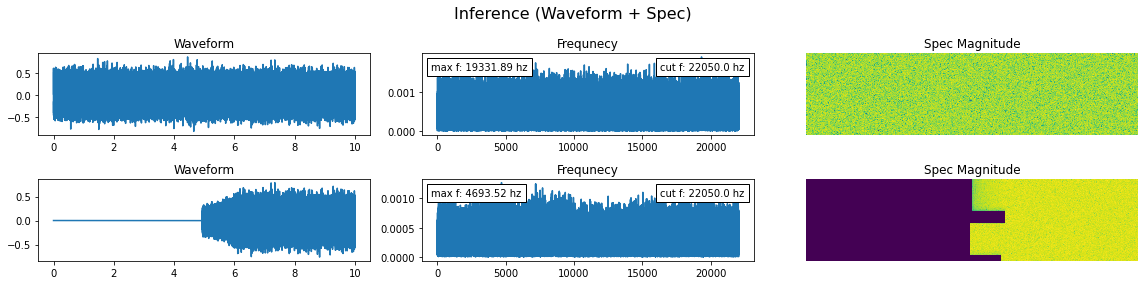

In [16]:
batch_idx = 0 # Choose batch sample to visualize 
fig, axes  = plt.subplots(2, 3, figsize=(16, 4))


for (use_wave, ax) in zip([waves, mixer_waves], axes):
    wave_visualize(use_wave[batch_idx], ax[0])
    ax[0].set_title('Waveform')
    fft_visualize(use_wave[batch_idx], ax[1])
    ax[1].set_title('Frequnecy')
    
for (use_mags, ax) in zip([mags, mixer_mags], axes):
    mask_visualize(amp2db_func(use_mags[batch_idx][0]), ax[2])
    ax[2].set_title('Spec Magnitude')


plt.suptitle('Inference (Waveform + Spec)', fontsize=16)
plt.tight_layout()
plt.show()